# Pendulum Lab Data Analysis

The following workbook walk through importing all of the data from the pendulum lab, and processing it.

The first step is to import all relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.signal import find_peaks

import glob
import re
import os

The LabView software outputs voltage data as a `*.lvm` file. The following function takes a file path, and converts the file to a Pandas DataFrame.

In [2]:
def read_lvm(filename, calibrate=False):
    ''' Take filename of *.lvm file and return data frame. '''
    
    df = pd.read_csv(filename, skiprows=22, delimiter='\t')
    
    df.columns=['t', 'V', 'COMMENTS']
    df = df.drop(['COMMENTS'], axis=1)
    
    return df

Another type of file we will have to process is the `*.csv` output from our Physics Traker motion analysis software. Similarly, we will want this data as a `pandas` DataFrame.

In [3]:
def process_tracker_file(filename):
    ''' Return a DataFrame with proper columns given tracker *.csv file. '''
    
    df = pd.read_csv(filename, header=1)
    df = df.drop(columns=['v_{x}', 'v_{y}', 'a_{x}', 'a_{y}'])
    
    return df

The next step is to calibrate the voltage output of the load cell in terms of force. All the calibration files are in the `force/` folder. Lets take a brief look at the list for files.

In [4]:
for file in glob.glob('force/*calibration*'):
    print(file)

force/calibration_0_g.lvm
force/calibration_100_g.lvm
force/calibration_10_g.lvm
force/calibration_200_g.lvm
force/calibration_20_g.lvm
force/calibration_50_g.lvm


While the mass used in each calibration file was given a round, nominal value, the true values were massed in class. We can put these in a dictionary.

In [5]:
real_mass = {
      '0':    0.0,
     '10':   10.0,
     '20':   20.2,
     '50':   50.0,
    '100':   99.8,
    '200':  200.2,
}

We will now read each `*.lvm` file, find the average voltage, and create a list of real masses and voltages.

In [11]:
m = []
v = []

for filename in glob.glob(r'force/*calibration*'):
    # Find the mass value.
    nominal_mass = re.search(r'\d{1,3}', filename).group()
    mass = real_mass[nominal_mass]
    
    # Find the voltage value.
    df = read_lvm(filename)
    voltage = df['V'].mean()
    
    # Add them to the list.
    m.append(mass)
    v.append(voltage)
    
calibration_data = pd.DataFrame({
    'MASS': m,
    'VOLTAGE': v,
})

calibration_data

,MASS,VOLTAGE
0,0.0,0.101089
1,99.8,0.100614
2,10.0,0.101039
3,200.2,0.100145
4,20.2,0.100989
5,50.0,0.100848


Now we can construct a transfer function that converts back and forth between voltage and mass.

In [87]:
# Perform a linear regression
c1, c0 = np.polyfit(calibration_data['VOLTAGE'],
                    calibration_data['MASS'], 1)

print(c1, c0)

def calibration_g(mass=None, voltage=None):
    # If the user provided voltage, return mass
    if voltage is not None:
        return c1 * voltage + c0
    
    # If the user provided mass, return voltage
    if mass is not None:
        return (mass - c0) / c1
    
def calibration_N(voltage):
    mass = c1 * voltage + c0
    mass += 9.81 * 498.0
    
    newtons = mass / 101.97
    
    return newtons

-212449.71370072104 21475.53851081779


Let's include a quick plot to check the validity of our calibration.

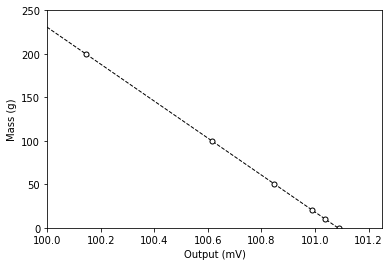

In [13]:
plt.scatter(calibration_data['VOLTAGE'] * 1000,
            calibration_data['MASS'],
            c='w', edgecolor='k', s=25)

m = np.linspace(0, 300, 1000)
plt.plot(calibration(mass=m) * 1000,
         m, c='k',
         linewidth=1,
         linestyle='--',
         zorder=0)

plt.xlim((100, 101.25))
plt.ylim((0, 250))

plt.xlabel('Output (mV)')
plt.ylabel('Mass (g)')

plt.savefig('calibration_plot', dpi=300)

plt.show()

Now we want to import our video analysis files, process them, and save them as cleaned analysis files with all the parameters we need.

In [66]:
# Identify all of the videos by their number.
videos = set()
for file in glob.glob(r'position/raw/*.csv'):
    n, l, deg = re.match(r'position/raw/(\d+)_(\d\d)cm_(\d\d)deg', file).groups()
    videos.add(n)
    
# Create a master data frame to hold all the data.
master_df = pd.DataFrame()

# Loop through each video.
for video in videos:  
    # Grab both the pendulum point, and pivot point tracker files.
    files = glob.glob('position/raw/*' + video + '*.csv')
    pendulum_file, pivot_file = files
    
    # Import them as DataFrames
    pendulum_df = process_tracker_file(pendulum_file)
    pivot_df    = process_tracker_file(pivot_file)
    
    # Based on the filename, identify the video number, release angle, and pendulum length.
    n, l, deg = re.match(r'position/raw/(\d+)_(\d\d)cm_(\d\d)deg', pendulum_file).groups()
    
    # Create a new blank DataFrame
    df = pd.DataFrame()
    
    # Pull togeth the pendulum and pivot tracking data.
    df['t']  = pendulum_df['t']
    df['x']  = pendulum_df['x']
    df['y']  = pendulum_df['y']
    df['x0'] = pivot_df['x']
    df['y0'] = pivot_df['y']
    
    # Covert to vector components.
    df['vx'] = df['x'] - df['x0']
    df['vy'] = df['y'] - df['y0']
    
    # Convert to radial coordinates.
    df['r']     = np.sqrt(df['vx']*df['vx'] + df['vy']*df['vy'])
    df['theta'] = np.arctan(df['vx'] / df['vy'])
    df['omega'] = df['theta'].diff().rolling(5).mean() / df['t'].diff()
    df['alpha'] = df['omega'].diff().rolling(5).mean() / df['t'].diff()
    
    # Add the descriptive parameters.
    df['n'] = str(n)
    df['l'] = float(l) / 100.
    df['angle_o'] = float(deg)
    df['theta_o'] = float(deg) * np.pi / 180.
    
    # Add the processsed file to the processed files list.
    new_name = 'position/processed/video_' + video + '_' + str(int(l) * 10) + 'mm_' + deg + 'deg'
    df.to_csv(new_name + '.csv', )

    # Append the video data to the master list.
    master_df = pd.concat([master_df, df]) 

Now we need to apply the two models Dan created to relate the tension to the accelerations. These values are hand computed.

In [73]:
master_df['m_bob'] = 404.6
master_df['m_CG']  = 498.0

master_df['l_CG']  = 0
master_df.loc[master_df['l'] == 0.250, 'l_CG'] = 0.29535
master_df.loc[master_df['l'] == 0.500, 'l_CG'] = 0.49861
master_df.loc[master_df['l'] == 0.750, 'l_CG'] = 0.70188
master_df.head()

,t,x,y,x0,y0,vx,vy,r,theta,omega,alpha,n,l,angle_o,theta_o,m_bob,m_CG,l_CG
0,0.000000,189.481737,242.455126,206.612849,356.135852,-17.131112,-113.680726,114.964266,0.149570,NaN,NaN,1638,0.25,15.0,0.261799,404.6,498.0,0.29535
1,0.033367,194.348222,241.691706,206.646598,356.125867,-12.298375,-114.434160,115.093123,0.107060,NaN,NaN,1638,0.25,15.0,0.261799,404.6,498.0,0.29535
2,0.066733,199.536311,241.401132,206.644681,356.149986,-7.108370,-114.748854,114.968815,0.061868,NaN,NaN,1638,0.25,15.0,0.261799,404.6,498.0,0.29535
3,0.100100,204.969473,241.161059,206.621751,356.129483,-1.652278,-114.968424,114.980296,0.014371,NaN,NaN,1638,0.25,15.0,0.261799,404.6,498.0,0.29535
4,0.133467,210.437120,241.484562,206.726035,356.116854,3.711084,-114.632292,114.692347,-0.032363,NaN,NaN,1638,0.25,15.0,0.261799,404.6,498.0,0.29535


I need to add a row for the force as predicted by Model I and again by Model II>

In [78]:
g = 9.81

df = master_df

df['F1'] = df['m_bob'] * 0.001 * (g * np.cos(df['theta']) + np.power(df['omega'], 2) * df['l'])
df['F2'] = df['m_CG']  * 0.001 * (g * np.cos(df['theta']) + np.power(df['omega'], 2) * df['l_CG'])

master_df = df

Now we just need to save out the ''master'' data frame.

In [79]:
master_df.to_csv(r'position/processed/master.csv')

Now we just need to read this massive file and create some plots.

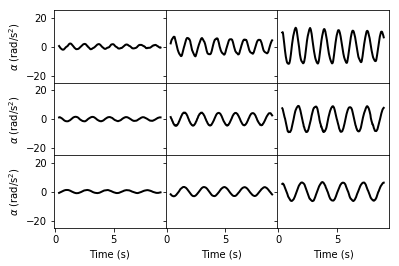

In [81]:
df = pd.read_csv('position/processed/master.csv')

f, ax = plt.subplots(3,3, sharex=True, sharey=True)
f.subplots_adjust(wspace=0, hspace=0)

for i, length in enumerate([0.250, 0.500, 0.750]):
    for j, degree in enumerate([5.0, 15.0, 30.0]):
        
        run = df[(df['l'] == length) & 
                 (df['angle_o'] == degree) &
                 (df['t'] < 9)]
        
        ax[i, j].plot(run['t'], run['alpha'], 
                      c='k', linewidth=2,
                      label='{l} mm, {a} deg'.format(l=length * 10000, a=degree))
        
        ax[i, j].set_ylim((-25, 25))
        
        if j == 0:
            ax[i, j].set_ylabel(r'$\alpha$ (rad/s$^2$)')
            
        if i == 2: 
            ax[i, j].set_xlabel('Time (s)')
            
f.savefig('acceleration', dpi=300)
f.show()
        

Now we want to graph the force as predicted by the two models, and compare it to the true force. We'll start by rewriting to `read_lvm` function to automatically calibrate our `*.lvm` files us.

In [96]:
def read_lvm_and_calibrate(filename):
    ''' Take filename of *.lvm file and return data frame. '''
    
    df = read_lvm(filename) 
    df['F'] = calibration_N(df['V'])
    
    return df

Now let's process all of our force files into a data frame, much the same way we did with position.

In [104]:
force_df = pd.DataFrame()

for file in glob.glob('force/data*'):
    df = read_lvm_and_calibrate(file)
    
    degree, length = re.search(r'data_(\d{1,2})_deg_at_(\d{3})_mm', file).groups()
    length = float(length) / 1000
    degree = float(degree)
    
    df['angle_o'] = degree
    df['l']       = l
    
    force_df = pd.concat([force_df, df])
    
len(force_df)

force_df.to_csv('master')

90201

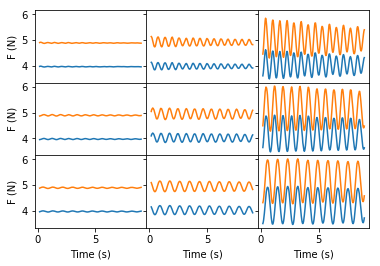

In [86]:
df = pd.read_csv('position/processed/master.csv')

f, ax = plt.subplots(3,3, sharex=True, sharey=True)
f.subplots_adjust(wspace=0, hspace=0)

for i, length in enumerate([0.250, 0.500, 0.750]):
    for j, degree in enumerate([5.0, 15.0, 30.0]):
        
        run = df[(df['l'] == length) & 
                 (df['angle_o'] == degree) &
                 (df['t'] < 9)]
        
        ax[i, j].plot(run['t'], run['F1'])
        ax[i, j].plot(run['t'], run['F2'])
        
        #ax[i, j].set_ylim((-25, 25))
        
        if j == 0:
            ax[i, j].set_ylabel(r'F (N)')
            
        if i == 2: 
            ax[i, j].set_xlabel('Time (s)')
            
f.savefig('force', dpi=300)
f.show()